# Now let's parse the log file
Note: you might want to do this in pieces in the tutorial. The way I worked through this/built it up is as follows:

Let's use Python's Pathlib to check that our file exists before we try to parse it

In [1]:
from pathlib import Path
filepath = Path('gctf-example/ctf/ctfindoutput/17may27a_L33_1d_00016gr_00125sq_v01_00007hln_00005enn_frames_ctffind3.log')
filepath.exists()

True

#### Open the file
Use a content manager to open and read in the log file
Context managers are used because they close the file when finished with reading it

In [2]:
with open(filepath) as f:
    print(f.readlines())

['CS[mm], HT[kV], AmpCnst, XMAG, DStep[um]\n', '2.7 300.0 0.07 45454.545454545454545454545455 50000\n', '18706.6135279480450000 17174.1264720519550000 85 1 0 Final Values\n']


#### Get the first line/header

Use next to grab the first line of the file since open returns a generator over the file


A generator is kind of like a loop except the next item is grabbed on the fly instead of everything loaded at once. Making a burger fresh per order (generator) vs. having them all frozen in back (list)

In [3]:
with open(filepath) as f:
    print(next(f))

CS[mm], HT[kV], AmpCnst, XMAG, DStep[um]



#### Parse the header
Now parse the header using strip to remove the new line and split to break on the commas

In [4]:
with open(filepath) as f:
    header = next(f).strip("\n").split(",")
    print(header)

['CS[mm]', ' HT[kV]', ' AmpCnst', ' XMAG', ' DStep[um]']


#### Get the other lines
Now lets look at the rest of the lines. That first next removes the first line, so the loop will print the rest

In [5]:
with open(filepath) as f:
    header = next(f).strip("\n").split(",") 
    for line in f:
        print(line)

2.7 300.0 0.07 45454.545454545454545454545455 50000

18706.6135279480450000 17174.1264720519550000 85 1 0 Final Values



#### Flag the last line
Let's pull out the last line since it's flagged differently. We know it's got `Final Values` at the end so lets look for that

In [6]:
with open(filepath) as f:
    header = next(f).strip("\n").split(",") 
    for line in f:
        if line.endswith("Final Values\n"):
            print("LAST: ", line)

LAST:  18706.6135279480450000 17174.1264720519550000 85 1 0 Final Values



#### Build spreadsheet by building list of lines

We create an empty list `loglines` to store our lines, and use pass to ignore the final values flag for now

In [7]:
loglines = []
with open(filepath) as f:
    header = next(f).strip("\n").split(",") 
    for line in f:
        if line.endswith("Final Values\n"):
            pass
        loglines.append(line.strip("\n").split(" "))
        

#### Create spreadsheet using pandas

In [8]:
import pandas as pd
pd.DataFrame(loglines, columns=header)

ValueError: 5 columns passed, passed data had 7 columns

#### Lets use that last line flag
The spreadsheet creation failed because the last line is 7 columns when we only have 5 column headers. To make sure we're always passing in 5 columns of data, let's strip the final marker out of the last line. 
(Note, I have no idea how this should actually be parsed-Amadee, Dominique?)

In [85]:
loglines = []
with open(filepath) as f:
    header = next(f).strip("\n").split(",") 
    for line in f:
        if line.endswith("Final Values\n"):
            line = line.strip("Final Values\n")    
        loglines.append(line.strip("\n").split())
        

#### Lets try again to make that spreadsheet

In [86]:
dflog = pd.DataFrame(loglines, columns=header)

In [87]:
dflog.head()

,CS[mm],HT[kV],AmpCnst,XMAG,DStep[um]
0,2.7,300.0,0.07,45454.545454545454545454545455,50000
1,18706.6135279480450000,17174.1264720519550000,85,1,0


# Try a larger file

Using the code above as a base, try to write a parser for:

`gctf-example/ctf/gctfoutput/17may27a_L33_1d_00016gr_00125sq_v01_00007hln_00005enn-a_EPA.log`


In [16]:
fpath = Path('gctf-example/ctf/gctfoutput/17may27a_L33_1d_00016gr_00125sq_v01_00007hln_00005enn-a_EPA.log')
fpath.exists()

True

#### Look at the raw data
the head linux command prints the first ten lines of a file.

In [21]:
!head gctf-example/ctf/gctfoutput/17may27a_L33_1d_00016gr_00125sq_v01_00007hln_00005enn-a_EPA.log

  Resolution      |CTFsim|    EPA( Ln|F| )    EPA(Ln|F| - Bg)    CCC
   29.671053      0.945488     13.716343       0.248113       1.000000 
   29.285715      0.955655     13.710673       0.245695       1.000000 
   28.910257      0.964906     13.704609       0.242774       1.000000 
   28.544304      0.973193     13.697906       0.239307       1.000000 
   28.187500      0.980462     13.690575       0.235139       1.000000 
   27.839506      0.986663     13.682796       0.230582       1.000000 
   27.500000      0.991745     13.674355       0.225398       1.000000 
   27.168674      0.995657     13.665446       0.219695       1.000000 
   26.845238      0.998350     13.655989       0.213459       1.000000 


#### read log file into spreadsheet
That header is a bit hard to parse because of the inconsistent spacing, so let's modify our current function.

In [45]:
loglines = []
with open(fpath) as f:
    header = next(f)

####  figure out how to get the column names

In [60]:
# let's try breaking up on whitespace (default)
header.split()

['Resolution',
 '|CTFsim|',
 'EPA(',
 'Ln|F|',
 ')',
 'EPA(Ln|F|',
 '-',
 'Bg)',
 'CCC']

In [61]:
# looking above, looks like the columns always have at least two spaces between
header.strip('\n').split("  ")

['',
 'Resolution',
 '',
 '',
 '|CTFsim|',
 '',
 'EPA( Ln|F| )',
 '',
 'EPA(Ln|F| - Bg)',
 '',
 'CCC']

can we maybe clean up the weird spaces? 
* replace " " with "" - space with no space
* use list comprehension to look at every element in the list

In [67]:
"hello goodbye".replace(" ","")

'hellogoodbye'

In [68]:
[col.replace(" ","") for col in header.strip('\n').split("  ")]

['',
 'Resolution',
 '',
 '',
 '|CTFsim|',
 '',
 'EPA(Ln|F|)',
 '',
 'EPA(Ln|F|-Bg)',
 '',
 'CCC']

can we drop the empty elements in the list? yes- filtering?
the empty string '' evaulates to None, so `if ''` is always false

In [70]:
[col.replace(" ","") for col in header.strip('\n').split("  ") if col]

['Resolution', '|CTFsim|', 'EPA(Ln|F|)', 'EPA(Ln|F|-Bg)', 'CCC']

In [72]:
columns = [col.replace(" ","") for col in header.strip('\n').split("  ") if col]
columns

['Resolution', '|CTFsim|', 'EPA(Ln|F|)', 'EPA(Ln|F|-Bg)', 'CCC']

#### Let's put all this code together:

In [88]:
loglines = []
with open(fpath) as f:
    header = next(f)
    columns = [col.replace(" ","") for col in header.strip('\n').split("  ") if col]
    for line in f:
        loglines.append(line.strip("\n").split())

#### let's make our spreadsheet
we're going to tell pandas that all the data are float numbers because we know this information and so it's safer to declare it

In [98]:
gctflog = pd.DataFrame(loglines, columns=columns, dtype='float')

In [99]:
gctflog.head()

,Resolution,|CTFsim|,EPA(Ln|F|),EPA(Ln|F|-Bg),CCC
0,29.671053,0.945488,13.716343,0.248113,1.0
1,29.285715,0.955655,13.710673,0.245695,1.0
2,28.910257,0.964906,13.704609,0.242774,1.0
3,28.544304,0.973193,13.697906,0.239307,1.0
4,28.187500,0.980462,13.690575,0.235139,1.0


In [100]:
gctflog.info()# check the data types of our columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 5 columns):
Resolution       862 non-null float64
|CTFsim|         862 non-null float64
EPA(Ln|F|)       862 non-null float64
EPA(Ln|F|-Bg)    862 non-null float64
CCC              862 non-null float64
dtypes: float64(5)
memory usage: 33.8 KB


# Let's create a new column

In [101]:
gctflog['Inverse Resolution'] = 1/gctflog['Resolution']

In [102]:
gctflog.columns

Index(['Resolution', '|CTFsim|', 'EPA(Ln|F|)', 'EPA(Ln|F|-Bg)', 'CCC',
       'Inverse Resolution'],
      dtype='object')

# Let's plot the Contrast Transfer Functions

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(111)
plt.axis([xstart,xend,ystart,yend])
# plt.xscale('log')

    plt.plot(recres,ctfsim,markersize=1,linewidth=0.5)
    plt.plot(recres,EPA2,markersize=2,linewidth=0.5)

    plt.title('gctf plot')

plt.xlabel('1/Resolution [1/A]  (Range: '+str(round(res[0],1))+':'+str(round(res[len(res)-1],1))+'A)')
plt.ylabel('EPA ( ln|F| )')

plt.grid(True)


In [103]:
gctflog.columns

Index(['Resolution', '|CTFsim|', 'EPA(Ln|F|)', 'EPA(Ln|F|-Bg)', 'CCC',
       'Inverse Resolution'],
      dtype='object')

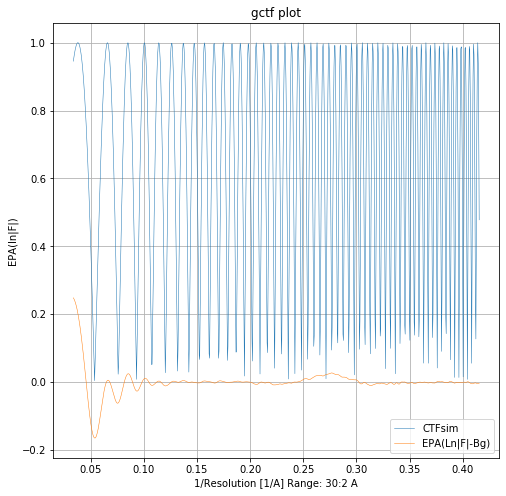

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('gctf plot')
ax.plot('Inverse Resolution', '|CTFsim|', markersize=1, linewidth=0.5, label='CTFsim', data=gctflog)
ax.plot('Inverse Resolution', 'EPA(Ln|F|-Bg)', markersize=2, linewidth=0.5, label='EPA(Ln|F|-Bg)', data=gctflog)
ax.set_xlabel(f'1/Resolution [1/A] Range: {gctflog["Resolution"].iloc[0]:.0f}:{gctflog["Resolution"].iloc[-1]:.0f} A')
ax.set_ylabel('EPA(ln|F|)')
ax.legend()
ax.grid(True)
              
fig.savefig("")

#### Aside: fstrings 
We can let Python handle a lot fo fancy string formatting using fstrings: https://docs.python.org/3/library/string.html?highlight=f%20string#format-string-syntax

In [122]:
f'Range: {gctflog["Resolution"].iloc[0]:.0f}:{gctflog["Resolution"].iloc[-1]:.0f} A'

'Range: 30:2 A'